<a href="https://colab.research.google.com/github/augustoaccorsi/autoscaling/blob/main/lstm_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)


In [160]:
data_xls = pd.read_excel('/content/cpu.xlsx', 'Sheet1', dtype=str, index_col=None)
data_xls.to_csv('/content/csvfile.csv', encoding='utf-8', index=False) 
dataset=pd.read_csv('/content/csvfile.csv', index_col='date',parse_dates=True)

dataset=dataset.dropna()
print('Shape of dataset',dataset.shape)
#dataset.head()
data.columns


Shape of dataset (230, 1)


Index(['value'], dtype='object')

In [161]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [162]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

154 76


In [163]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [164]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [165]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
152/152 - 2s - loss: 0.1971
Epoch 2/100
152/152 - 0s - loss: 0.1467
Epoch 3/100
152/152 - 0s - loss: 0.1211
Epoch 4/100
152/152 - 0s - loss: 0.1090
Epoch 5/100
152/152 - 0s - loss: 0.1000
Epoch 6/100
152/152 - 0s - loss: 0.0921
Epoch 7/100
152/152 - 0s - loss: 0.0857
Epoch 8/100
152/152 - 0s - loss: 0.0806
Epoch 9/100
152/152 - 0s - loss: 0.0761
Epoch 10/100
152/152 - 0s - loss: 0.0731
Epoch 11/100
152/152 - 0s - loss: 0.0714
Epoch 12/100
152/152 - 0s - loss: 0.0697
Epoch 13/100
152/152 - 0s - loss: 0.0691
Epoch 14/100
152/152 - 0s - loss: 0.0689
Epoch 15/100
152/152 - 0s - loss: 0.0680
Epoch 16/100
152/152 - 0s - loss: 0.0679
Epoch 17/100
152/152 - 0s - loss: 0.0675
Epoch 18/100
152/152 - 0s - loss: 0.0674
Epoch 19/100
152/152 - 0s - loss: 0.0677
Epoch 20/100
152/152 - 0s - loss: 0.0675
Epoch 21/100
152/152 - 0s - loss: 0.0674
Epoch 22/100
152/152 - 0s - loss: 0.0673
Epoch 23/100
152/152 - 0s - loss: 0.0671
Epoch 24/100
152/152 - 0s - loss: 0.0675
Epoch 25/100
152/152 - 0s

In [166]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.63 RMSE
Test Score: 30.04 RMSE


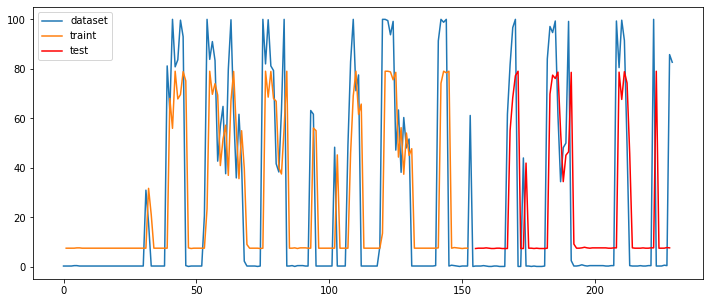

In [168]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.subplots(figsize=(12, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color='red')
plt.legend(["dataset", "traint", 'test'])
plt.show()